In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect, TVDNRankTuning
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyTVDN.tmpUtils import *
from scipy.signal import lfilter, firls, decimate
%matplotlib inline
plt.style.use('ggplot')

In [3]:
from pprint import pprint
import pickle
from easydict import EasyDict as edict
import warnings
from pyTVDN.TVDNutils import *
from pyTVDN.utils import in_notebook
if in_notebook():
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm

class TVDNDetect1(TVDNDetect):
    def SmoothEst(self):
        if self.nYmat is None:
            self._Preprocess()
        d, n = self.nYmat.shape
        acTime = n / self.paras.freq
        self.ptime = np.linspace(0, acTime, n)
        self.time = np.linspace(0, self.paras.T, n)
        divNum = 100
        if self.smoothType == "bspline":
            self.dXmat = np.zeros((d, n))
            self.Xmat = np.zeros((d, n))
            if n%divNum == 0:
                numLoop = int(n/divNum)
            else:
                numLoop = int(n/divNum) + 1
            for i in range(numLoop):
                if (i+1)*divNum <= n:
                    low = i*divNum
                    up = (i+1)*divNum
                else:
                    low = i*divNum
                    up = n
                self.dXmat[:, low:up], self.Xmat[:, low:up] = GetBsplineEst(self.nYmat[:, low:up], self.time[low:up], 
                                                                            lamb=self.paras.lamb)
        elif self.smoothType == "fourier":
            self.dXmat, self.Xmat = GetFourierEst(self.nYmat, self.time, nbasis=self.paras.nbasis)
            

In [4]:
resDir = Path("../results")
dataDir = Path("../data/MEG-resting-state")

In [5]:
datFil = list(dataDir.glob("*8002*min.mat"))[0]
print(datFil)

MEG = loadmat(datFil)
data = MEG["DK_timecourse"]
data.shape

../data/MEG-resting-state/lcmv_result_8002-101_wo_filtering_min.mat


(68, 35999)

The time course is 60 seconds, so the frequency is 600 Hz

###  Data preprocessing

In [6]:
q = 5
dataN = decimate(data, q=q)
dataN = detrend(dataN)

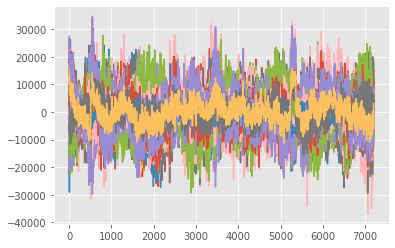

In [7]:
d, n = dataN.shape
for i in range(d):
    plt.plot(dataN[i, :])

### Tuning kappa

In [8]:
paras = edict()
paras.Lmin = 200
paras.wh = 10
paras.MaxM = 20
paras.fct = 0.5
paras.r = None
paras.freq = 120
paras.lamb = 1e-2
paras.T = 2
paras.is_detrend = False
paras.decimateRate = None
paras.kappa = 2.77
paras.downRate = 20

detObjs = []
for i in range(5):
    dataPart = data[:, i::5]
    dataPart = detrend(dataPart)
    detPart = TVDNDetect(Ymat=dataPart, dataType="MEG", 
                         saveDir=None, #"MEGst02", 
                         fName="MEG1",
                         showProgress=True, 
                         MaxM=paras.MaxM,
                         Lmin=paras.Lmin, 
                         lamb=paras.lamb, 
                         kappa=paras.kappa, 
                         freq=paras.freq,
                         r=paras.r,
                         T=paras.T,
                         is_detrend=paras.is_detrend,
                         decimateRate=paras.decimateRate, 
                         downRate=paras.downRate)
    detPart.Screening(wh=paras.wh)
    detPart()
    kappas = np.arange(1, 4, 0.001)
    detPart.TuningKappa(kappas)
    detObjs.append(detPart)

The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 2.77,
 'lamb': 0.01,
 'nbasis': 10,
 'r': None}



The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 2.77,
 'lamb': 0.01,
 'nbasis': 10,
 'r': None}



The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 2.77,
 'lamb': 0.01,
 'nbasis': 10,
 'r': None}



The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 2.77,
 'lamb': 0.01,
 'nbasis': 10,
 'r': None}



The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 2.77,
 'lamb': 0.01,
 'nbasis': 10,
 'r': None}


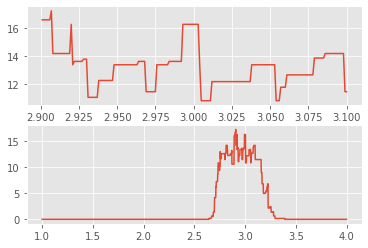

In [9]:
numchgss = []
for i in range(5):
    numchgs = detObjs[i].numchgs
    numchgss.append(numchgs)
    
numchgssArr = np.array(numchgss)
varsAll = np.var(numchgssArr, axis=0)

kpidxs = ((kappas >= 2.9).astype(np.int) + (kappas<=3.1)) == 2
subVarsAll = varsAll[kpidxs]
subKappas = kappas[kpidxs]

plt.subplot(211)
plt.plot(subKappas, subVarsAll)
plt.subplot(212)
plt.plot(kappas, varsAll)

In [10]:
optKaIdx = np.argmin(subVarsAll)
optKappa = subKappas[optKaIdx]
print(optKappa)

3.004999999999779


## Detection on data with screening and no HPF

In [8]:
paras = edict()
paras.Lmin = 200
paras.wh = 10
paras.MaxM = 20
paras.fct = 0.5
paras.r = None
paras.freq = 120
paras.lamb = 1e-2
paras.T = 2
paras.is_detrend = False
paras.decimateRate = None
paras.kappa = 3.005
paras.downRate = 20

In [12]:
detRaw = TVDNDetect(Ymat=dataN, dataType="MEG", 
                     saveDir=None, #"MEGst02", 
                     fName="MEG1",
                     showProgress=True, 
                     MaxM=paras.MaxM,
                     Lmin=paras.Lmin, 
                     lamb=paras.lamb, 
                     kappa=paras.kappa, 
                     freq=paras.freq,
                     r=paras.r,
                     T=paras.T,
                     is_detrend=paras.is_detrend,
                     decimateRate=paras.decimateRate, 
                     downRate=paras.downRate)

The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 3.004999999999779,
 'lamb': 0.01,
 'nbasis': 10,
 'r': None}


In [13]:
detRaw.Screening(wh=paras.wh)
detRaw()

Sequences after B-spline

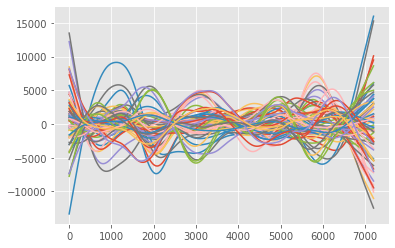

In [14]:
for i in range(detRaw.Xmat.shape[0]):
    plt.plot(detRaw.Xmat[i, :])

+-------------+--------------------------------------+-------------------+------+
| Num of CPTs |            Estiamted CPTs            |        MSE        | Rank |
+-------------+--------------------------------------+-------------------+------+
|      7      | [ 883 1588 2544 3284 4835 6457 6844] | 6.078730721441804 |  5   |
+-------------+--------------------------------------+-------------------+------+


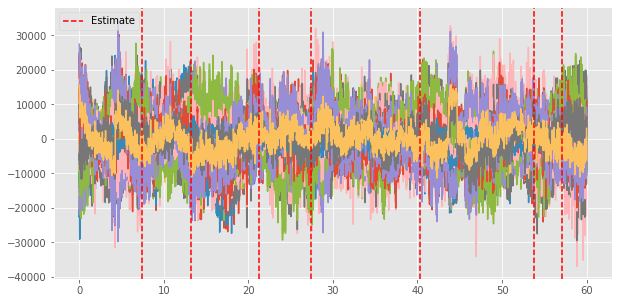

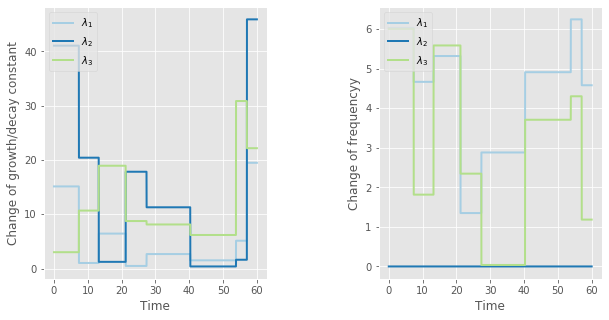

In [15]:
print(detRaw)
detRaw.PlotEcpts()
detRaw.PlotEigenCurve()

In [16]:
print(np.diff(detRaw.ecpts))

[ 705  956  740 1551 1622  387]


### Detection without Screening

In [12]:
detRawNo = TVDNDetect(Ymat=dataN, dataType="MEG", 
                     saveDir="../results/MEG-RSN-rankada", 
                     fName="MEG-RS8002",
                     showProgress=True, 
                     MaxM=paras.MaxM,
                     Lmin=paras.Lmin, 
                     lamb=paras.lamb, 
                     kappa=paras.kappa, 
                     freq=paras.freq,
                     r=paras.r,
                     T=paras.T,
                     is_detrend=paras.is_detrend,
                     decimateRate=paras.decimateRate, 
                     downRate=paras.downRate)

The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG-RS8002',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 3.005,
 'lamb': 0.01,
 'nbasis': 10,
 'r': None}


In [13]:
detRawNo()

/home/huaqingj/MyResearch/TVDN/pyTVDN/TVDNclass.py:287: UserWarning: As loading the saved results, kappa will be ignored
  warnings.warn("As loading the saved results, kappa will be ignored", UserWarning)


+-------------+--------------------------------------+------------------+------+
| Num of CPTs |            Estiamted CPTs            |       MSE        | Rank |
+-------------+--------------------------------------+------------------+------+
|      7      | [ 875 1594 2536 3283 4855 6446 6841] | 6.04427675581934 |  5   |
+-------------+--------------------------------------+------------------+------+


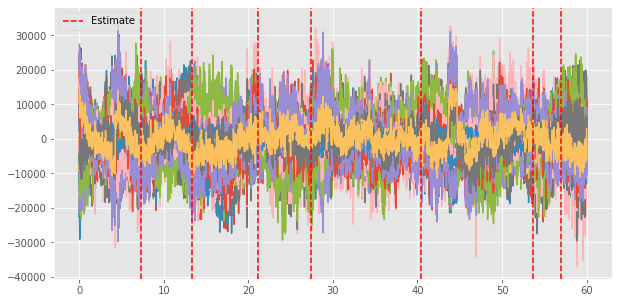

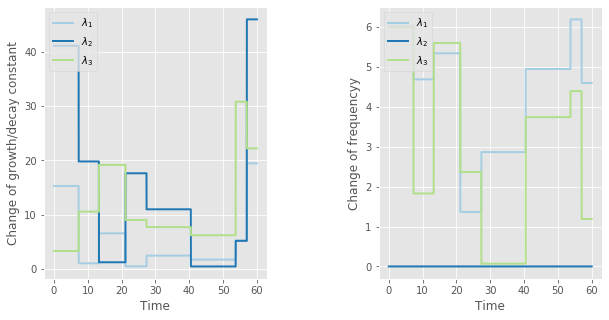

In [14]:
print(detRawNo)
detRawNo.PlotEcpts()
detRawNo.PlotEigenCurve()

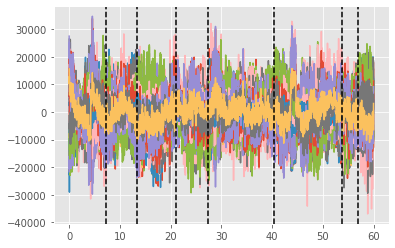

In [46]:
d, n = detRawNo.nYmat.shape
acTime = n / detRawNo.paras.freq
ajfct = n/acTime
plt.figure(figsize=[6, 4])
for i in range(d):
    plt.plot(detRawNo.ptime, detRawNo.nYmat[i, :], "-")

for j, ecpt in enumerate(detRawNo.ecpts):
    if j == 0:
        plt.axvline(ecpt/ajfct, color="black", linestyle="--", label="Estimate")
    else:
        plt.axvline(ecpt/ajfct, color="black", linestyle="--")

#plt.legend()
#plt.legend(loc="upper left")
plt.savefig("../plots/MEG-RSN-8002-TVDN-ecpts.jpg", bbox_inches='tight')
plt.show() 

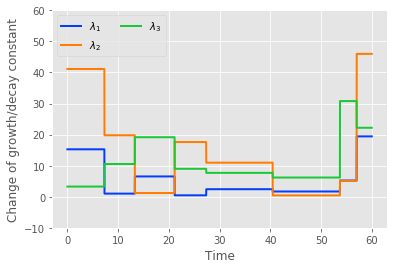

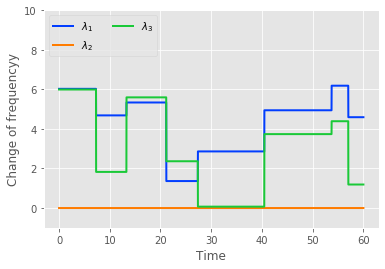

In [47]:
freq = detRawNo.paras.freq
numChgCur = len(detRawNo.ecpts)
LamMs = detRawNo.RecResCur.LamMs
rAct, n = LamMs.shape
pltIdxs = np.arange(1, rAct)[np.diff(np.abs(LamMs), axis=0).astype(np.bool).all(axis=1)] 
pltIdxs = np.concatenate([[0], pltIdxs])
acTime = n / detRawNo.paras.freq
ReLamMs = freq*LamMs.real/(acTime/detRawNo.paras.T)
ImLamMs = freq*LamMs.imag/((2*np.pi)*(acTime/detRawNo.paras.T))
cols = sns.color_palette("bright", len(pltIdxs))

plt.figure(figsize=[6,4])
for i0, i in enumerate(pltIdxs):
    labs = f"$\\lambda_{i0+1}$"
    plt.plot(detRawNo.ptime, np.abs(ReLamMs[i, :]), label=labs, 
             color=cols[i0], linewidth=2)
plt.ylabel("Change of growth/decay constant")
plt.xlabel("Time")
plt.ylim([-10, 60])
_ = plt.legend(loc="upper left", ncol=2)
plt.savefig("../plots/MEG-RSN-8002-eigReal.jpg", bbox_inches='tight')
plt.show()

plt.figure(figsize=[6,4])
for i0, i in enumerate(pltIdxs):
    labs = f"$\\lambda_{i0+1}$"
    plt.plot(detRawNo.ptime, np.abs(ImLamMs[i, :]), label=labs, 
             color=cols[i0], linewidth=2)
plt.ylabel("Change of frequencyy")
plt.ylim([-1,10])
plt.xlabel("Time")
_ = plt.legend(loc="upper left", ncol=2)
plt.savefig("../plots/MEG-RSN-8002-eigImag.jpg", bbox_inches='tight')
plt.show() 

### Save results

In [61]:
def obtainwU(DetObj):
    eigVecs = DetObj.midRes.eigVecs[:, :DetObj.paras.r]
    kpidxs = np.concatenate([[0], DetObj.ecpts]).astype(np.int)
    eigVals = DetObj.RecResCur.LamMs[:, kpidxs]
    wU = eigVecs.dot(eigVals)
    return wU

def minmax(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den

In [62]:
wUst = obtainwU(detRawNo)
wUst = np.transpose(wUst)
abswUst = np.abs(wUst)
# save to npy file
with open("../results/MEG-RSN-wU/MEGRS8002_NonScreening_abswU_full.npy", "wb") as f:
    np.save(f, abswUst)
with open("../results/MEG-RSN-wU/MEGRS8002_NonScreening_wU_full.npy", "wb") as f:
    np.save(f, wUst)

abswUstMM = np.zeros_like(abswUst)
for i, col in enumerate(abswUst):
    lh = minmax(col[:34])
    rh = minmax(col[34:])
    abswUstMM[i, :34] = lh
    abswUstMM[i, 34:] = rh

In [63]:
import pandas as pd

fcR = pd.read_csv('../data/brain_plot_meg/DK_dic68.csv').set_index('Unnamed: 0')
rowNames = list(fcR.index)
colNames = np.array(fcR.columns)

fcRarr = np.array(fcR)

# minmax 
fcRarrMM = np.zeros_like(fcRarr)
for i, fcRar in enumerate(fcRarr):
    lh = minmax(fcRar[:34])
    rh = minmax(fcRar[34:])
    fcRarrMM[i, :34] = lh
    fcRarrMM[i, 34:] = rh

In [64]:
from collections import OrderedDict as odict
csvD = odict()
for i, name in enumerate(colNames):
    csvD[name] = abswUstMM[:, i]

csvD = pd.DataFrame(csvD)
csvD.to_csv("../results/MEG-RSN-wU/wU_NonScreening_minmax_RS8002.csv")

In [65]:
import scipy.stats as ss
from collections import defaultdict as ddict
corrs = ddict(list)
for absU in abswUstMM:
    for j, name in enumerate(rowNames):
        corrs[name].append(ss.pearsonr(fcRarrMM[j, :], absU)[0])
        #corrs[name].append(ss.spearmanr(fcRarrMM[j, :], absU)[0])
    
corrsDF = pd.DataFrame(corrs)
corrsDF.to_csv("../results/MEG-RSN-wU/corrs_NonScreenig_RS8002.csv")
corrsDF

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
0,-0.423840,0.140380,-0.021927,-0.184911,0.150755,-0.048531,0.305698
1,-0.207895,0.324033,-0.101770,0.194592,0.024635,0.035799,-0.148229
2,-0.125979,0.448241,0.086468,-0.001415,-0.017445,0.053414,-0.161428
3,-0.165875,-0.031920,0.177884,0.040991,-0.164750,-0.151670,0.257941
4,-0.063974,0.278145,-0.003732,0.194291,0.101504,0.066373,-0.334350
5,-0.122384,0.436448,-0.123406,0.069899,0.059697,-0.030963,-0.126923
6,-0.191302,0.136055,-0.217145,0.287605,-0.070036,-0.148672,0.122609
7,0.180662,0.022976,0.620707,0.011554,-0.238351,0.039013,-0.286462


#### corr of wU via the second way

In [66]:
def obtainAbswU2(DetObj):
    absEigVecs = np.abs(DetObj.midRes.eigVecs[:, :DetObj.paras.r])
    kpidxs = np.concatenate([[0], DetObj.ecpts]).astype(np.int)
    absEigVals = np.abs(DetObj.RecResCur.LamMs[:, kpidxs])
    wU = absEigVecs.dot(absEigVals)
    return np.abs(wU)

abswUst2 = obtainAbswU2(detRawNo)
abswUst2 = np.transpose(abswUst2)

abswUst2MM = np.zeros_like(abswUst2)
for i, col in enumerate(abswUst2):
    lh = minmax(col[:34])
    rh = minmax(col[34:])
    abswUst2MM[i, :34] = lh
    abswUst2MM[i, 34:] = rh
    
corrs = ddict(list)
for abswU in abswUst2MM:
    for j, name in enumerate(rowNames):
        corrs[name].append(ss.pearsonr(fcRarrMM[j, :], abswU)[0])
    
corrsDF2 = pd.DataFrame(corrs)
corrsDF2

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
0,-0.098071,0.252131,0.383789,-0.110322,0.073718,0.069987,-0.225642
1,-0.120776,0.264913,0.355077,-0.104501,0.117826,0.095531,-0.270249
2,-0.229216,0.275330,0.150218,-0.059305,0.110616,0.021043,-0.077644
3,-0.058081,0.214158,0.422281,-0.133414,0.015827,0.043706,-0.152905
4,-0.125217,0.265893,0.348009,-0.104681,0.131813,0.105285,-0.285032
5,-0.230936,0.289095,0.161228,-0.065143,0.147474,0.053553,-0.141430
6,-0.216366,0.277986,0.183572,-0.067275,0.115023,0.034065,-0.110445
7,-0.048503,0.240187,0.445198,-0.120128,0.066137,0.089990,-0.284204


#### Corr of U 

In [67]:
r = detRawNo.paras.r
rUs = detRawNo.midRes.eigVecs[:, :r]
kpidxs = np.where(np.diff(np.concatenate([[np.Inf], np.abs(rUs[0, :])])) != 0)[0]
Us = rUs[:, kpidxs]
absUs = np.abs(Us).T

absUsMM = np.zeros_like(absUs)
for i, col in enumerate(absUs):
    lh = minmax(col[:34])
    rh = minmax(col[34:])
    absUsMM[i, :34] = lh
    absUsMM[i, 34:] = rh
    
Ucorrs = ddict(list)
for absU in absUsMM:
    for j, name in enumerate(rowNames):
        Ucorrs[name].append(ss.pearsonr(fcRarrMM[j, :], absU)[0])
    
UcorrsDF = pd.DataFrame(Ucorrs)
#UcorrsDF.to_csv("../results/MEG-eye-wU/Ucorrs_NonScreenig_RS8002.csv")
UcorrsDF

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
0,-0.166150,0.297917,0.188071,-0.106696,0.263555,0.137482,-0.308555
1,0.198696,0.070400,0.678145,-0.143218,-0.111123,0.122351,-0.361358
2,-0.241052,0.075671,0.022794,-0.065132,-0.029007,-0.062426,0.256333


### Results of other methods

In [19]:
import rpy2.robjects as robj

robj.r.source("../Rcode/utils.R")
RsegCorr = robj.r["segCorr"]
RsegPCA = robj.r["segPCA"]
RsegDMD = robj.r["DMD"]
RchgF = robj.r["chgF"]
RsegDMDOrg = robj.r["DMDOrg"]
RsegPCAOrg = robj.r["segPCAOrg"]

In [20]:
ecptss = edict()
d, n = dataN.shape

paras = edict()
paras.rank = 0.8
paras.slidew = 40


wsizes = [200, 400, 600, 800, 1000, 1200]

for wsize in wsizes:
    ecpts = edict()
    paras.seqw = np.arange(1, n-wsize, paras.slidew)
    rSeqw = py2Rvec(paras.seqw)
    rYmat = py2Rmat(dataN)
    
    
    # Detection results for DCOR
    rDCORres = RsegCorr(rYmat, wsize, rSeqw)
    rDCORecpts = RchgF(rDCORres, rSeqw)
    ecpts.DCOR = np.array(rDCORecpts)
        
    # Detection results for PCA
    rPCAres = RsegPCA(rYmat, wsize, rSeqw, rank=paras.rank)
    rPCAecpts = RchgF(rPCAres, rSeqw)
    ecpts.PCA = np.array(rPCAecpts)
        
    # Detection results for DMD
    rDMDres = RsegDMD(rYmat, wsize, rSeqw, rank=paras.rank)
    rDMDecpts = RchgF(rDMDres, rSeqw)
    ecpts.DMD = np.array(rDMDecpts)
    
    ecptss[f'w{wsize}'] = ecpts

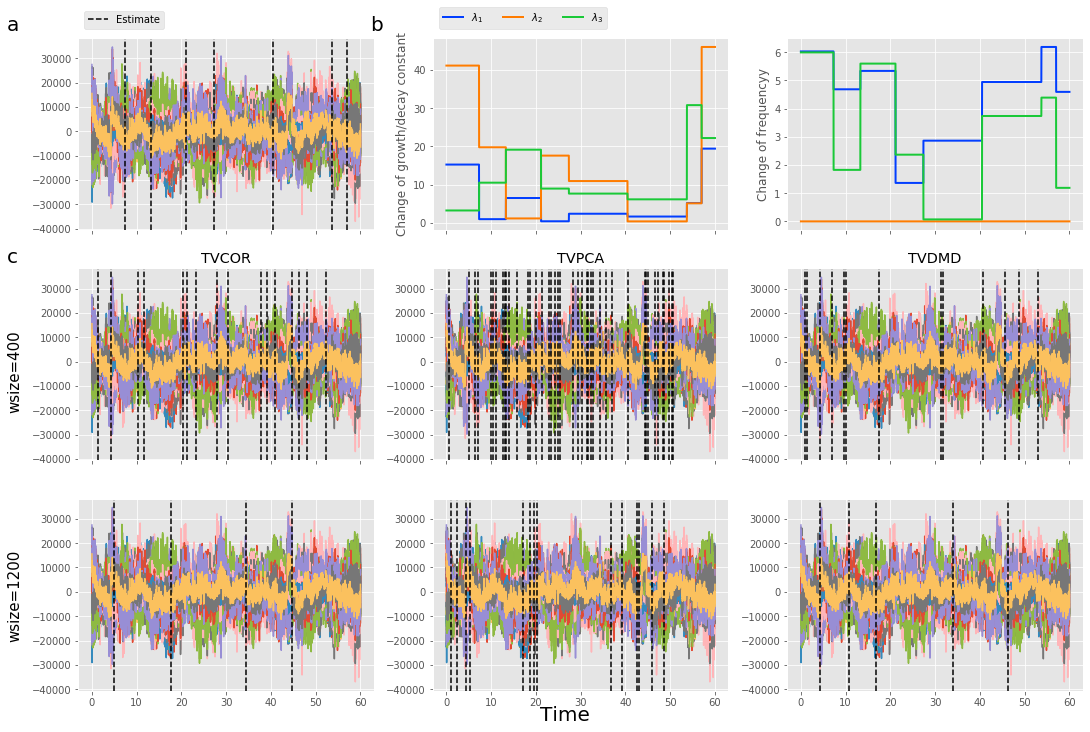

In [44]:
ptime = np.linspace(0, 60, n)
ajfct = n/60
names = ["DCOR", "PCA", "DMD"]
wsizes = [400, 1200]


fig, axs= plt.subplots(nrows=len(wsizes)+1, ncols=3, sharex=True, sharey=False, figsize=(18, 4*len(wsizes)+4))

for i in range(d):
    axs[0, 0].plot(detRawNo.ptime, detRawNo.nYmat[i, :], "-")

for j, ecpt in enumerate(detRawNo.ecpts):
    if j == 0:
        axs[0, 0].axvline(ecpt/ajfct, color="black", linestyle="--", label="Estimate")
    else:
        axs[0, 0].axvline(ecpt/ajfct, color="black", linestyle="--")
        
for i0, i in enumerate(pltIdxs):
    labs = f"$\\lambda_{i0+1}$"
    axs[0, 1].plot(detRawNo.ptime, np.abs(ReLamMs[i, :]), label=labs, 
             color=cols[i0], linewidth=2)
axs[0, 1].set_ylabel("Change of growth/decay constant")
#axs[0, 1].set_ylim([-10, 75])
#axs[0, 1].legend(loc="upper left")

for i0, i in enumerate(pltIdxs):
    labs = f"$\\lambda_{i0+1}$"
    axs[0, 2].plot(detRawNo.ptime, np.abs(ImLamMs[i, :]), label=labs, 
             color=cols[i0], linewidth=2)
axs[0, 2].set_ylabel("Change of frequencyy")
#axs[0, 2].set_ylim([-1, 12])
#axs[0, 2].legend(loc="upper right")

for fi in range(1, len(wsizes)+1):
    for fj in range(3):
        for i in range(d):
            axs[fi, fj].plot(ptime, dataN[i, :])
        for ecpt in ecptss[f"w{wsizes[fi-1]}"][names[fj]]:
            axs[fi, fj].axvline(ecpt/ajfct, color="black", linestyle="--")
            
axs[1, 0].set_title("TVCOR")
axs[1, 1].set_title("TVPCA")
axs[1, 2].set_title("TVDMD")

handles, labels = axs[0, 0].get_legend_handles_labels()
axs[0, 0].legend(handles, labels, loc=(0.02, 1.05), ncol=1)
handles, labels = axs[0, 1].get_legend_handles_labels()
axs[0, 1].legend(handles, labels, loc=(0.02, 1.05), ncol=3)


fig.text(0.5, 0.09, 'Time', ha='center', fontsize=20)
fig.text(0.07, 8/9, "a",  fontsize=20)
fig.text(0.35, 8/9, "b",  fontsize=20)
fig.text(0.07, 0.62, "c",  fontsize=20)

for i in range(len(wsizes)):
    fig.text(0.07, 0.185+i*0.265, f"wsize={wsizes[::-1][i]}", rotation="vertical", fontsize=15)
    
plt.savefig("../plots/MEG-RSN-8002-res-combo.jpg", bbox_inches='tight')

In [48]:
plt.figure(figsize=[6, 4])
for wsize in wsizes[:]:
    for i in range(d):
        plt.plot(ptime, dataN[i, :])
    for jj, ecpt in enumerate(ecptss[f"w{wsize}"]["DCOR"]):
        if jj == 0:
            plt.axvline(ecpt/ajfct, color="black", linestyle="--", label="Estimate")
        else:
            plt.axvline(ecpt/ajfct, color="black", linestyle="--")
    plt.savefig(f"../plots/MEG-RSN-8002-TVCOR-w{wsize}-ecpts.jpg", bbox_inches='tight')
    plt.close()
    
    
    
plt.figure(figsize=[6, 4])
for wsize in wsizes[:]:
    for i in range(d):
        plt.plot(ptime, dataN[i, :])
    for jj, ecpt in enumerate(ecptss[f"w{wsize}"]["DMD"]):
        if jj == 0:
            plt.axvline(ecpt/ajfct, color="black", linestyle="--", label="Estimate")
        else:
            plt.axvline(ecpt/ajfct, color="black", linestyle="--")
    plt.savefig(f"../plots/MEG-RSN-8002-TVDMD-w{wsize}-ecpts.jpg", bbox_inches='tight')
    plt.close()    
    
    
plt.figure(figsize=[6, 4])
for wsize in wsizes[:]:
    for i in range(d):
        plt.plot(ptime, dataN[i, :])
    for jj, ecpt in enumerate(ecptss[f"w{wsize}"]["PCA"]):
        if jj == 0:
            plt.axvline(ecpt/ajfct, color="black", linestyle="--", label="Estimate")
        else:
            plt.axvline(ecpt/ajfct, color="black", linestyle="--")
    plt.savefig(f"../plots/MEG-RSN-8002-TVPCA-w{wsize}-ecpts.jpg", bbox_inches='tight')
    plt.close()